# Behavorial-Cloning Project
## - Brian Erickson
This is my implementation of the Udacity Self Driving Car class project "Behavioral Cloning".

The goal is to record driving input and images using a driving simulator, use the recorded input and images to train a neural network that will predict steering angles and then use the predicted steering angles to drive the same car in the same simulator.

**Todo:**

- Make a movie of the images vs. the steering angles for each
- Try the left/right images with steering offset
- Cut the video segments before applying filtering
- Record video and steering angles from the auto-pilot, make movies to show what went wrong
- Identify areas where the steering is bad in output and record input that shows correct steering


### Imports and Helper Functions

The helper functions below will be used throughout the notebook.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import math
import time
import skimage.transform
import random
import os
from ipywidgets import widgets
from IPython.display import display
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten
from keras.layers import Dense, Lambda, SeparableConvolution2D, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.activations import relu, elu

%matplotlib inline

Using TensorFlow backend.


In [2]:
def plot_image(img,title=None):
    '''
    Plots a single RGB or Greyscale image with no border
    '''
    cmap = 'gray' if np.ndim(img) == 2 else None
    plt.axis('off')
    plt.imshow(img, cmap=cmap, interpolation='none')
    if title is not None:
        plt.title(title)
        
def plot_images(l, images_per_line = 10, image_size_inches = 1.0, title=None):
    """
    Plots images in a grid
    """
    image_size_inches *= 2 # because of the funny dpi in notebook
    fig=plt.figure()
    if title is not None:
        fig.suptitle(title)
    line_count=math.ceil(len(l)/images_per_line)
    fig.set_size_inches(w=images_per_line*image_size_inches*l[0].shape[1]/l[0].shape[0],h=line_count*image_size_inches)
    for i in range(len(l)):
        img=l[i]
        plt.subplot(line_count,images_per_line,i+1)
        plot_image(img)


In [3]:
def elements_at_indexes(*lists, indexes):
    if len(lists)==1:
        l=lists[0]
        return [l[i] for i in indexes]
    else:
        return [elements_at_indexes(l,indexes=indexes) for l in lists]

# example usages
a = [2,4,6,10]
b = [3,6,9,12]
indexes = [1,3]
print (elements_at_indexes(a,b,indexes=indexes))
print (elements_at_indexes(a,indexes=indexes))



[[4, 10], [6, 12]]
[4, 10]


In [4]:
def split(*lists,n=None,ratio=None):
    if ratio is not None:
        n=int(len(lists[0])*ratio)
    if n is None or n > len(lists[0]):
        n = len(lists[0])
    rv = []
    for l in lists:
        rv.append(l[:n])
        rv.append(l[n:])
    return rv

In [5]:
# based on http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
# and modified
def smooth(x, window_len=11, window='hanning'):
    """
    returns a smoothed version of x.
    
    Ends are padded with reflections

    input:
        x: 1d array
        window_len: smoothing window length; should be an odd integer
        window: kernel type: 'flat', 'hanning', 'hamming', 'bartlett', 'blackman' 

    output:
        the smoothed signal, same size as x
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[window_len//2:x.size+window_len//2]

In [6]:
def random_sample(*lists, n=None, ratio = None, return_remainder = False, random_order=True):
    """
    Returns parallel lists with n random samples from lists without replacement
    
    parameters
    ---
    n                   - number of samples to return in primary set
    ratio               - ratio of samples to return in primary set
                          if and and ratio ar both None, all samples are returned
    return_remainder    - returns two sets of lits, one with the n or 
                          ratio samples, the other with the remaining samples
    random_order        - if True, samples are returned in random order, otherwise
                          they are returned in the same order as in the original lists
    
    """
    list_length = len(lists[0])
        
    all_indexes = list(range(list_length))
    np.random.shuffle(all_indexes)
    i1,i2 = split(all_indexes, n=n, ratio=ratio)
    
    if random_order == False:
        i1.sort()
        i2.sort()
    rv  = []
    for l in lists:
        rv.append(elements_at_indexes(l,indexes=i1))
        if return_remainder:
            rv.append(elements_at_indexes(l,indexes=i2))
    if len(rv) == 1:
        rv = rv[0]
    return rv
        

In [7]:
# examples of random_sample
a=[1,2,3,4,5,6]
b=[2,4,6,7,10,12]
#print(random_sample(a,b,n=4,return_remainder=True))
print (random_sample(a))
print (random_sample(a,b))
print (random_sample(a,b,ratio=0.8,return_remainder=True))

[6, 1, 2, 5, 4, 3]
[[1, 2, 6, 3, 5, 4], [2, 4, 12, 6, 10, 7]]
[[3, 5, 4, 2], [6, 1], [6, 10, 7, 4], [12, 2]]


In [8]:
def read_driving_log(folder='recordings'):
    csv_path = folder+'/driving_log.csv'
    csv_column_names = [
        'center',
        'left',
        'right',
        'steering',
        'throttle',
        'brake',
        'speed']
    
    return pd.read_csv(csv_path,names=csv_column_names,skiprows=1)

In [9]:
# demo data and simulator data use different format,
# this handles both
def actual_file_path_for_image(data_folder, filename):
    rv = "/".join((data_folder,"IMG",filename.split("\\")[-1]))
    rv = rv.replace("/IMG/IMG","/IMG")
    return rv
    

def read_logs(include_side_images = True, side_image_correction=0.1):
    image_files = []
    steering_angles = []
    data_folder = '/home/brian/CarND/SimulatorData'
    for folder in os.listdir(data_folder):
        log_path = os.path.join(data_folder,folder)
        log = read_driving_log(log_path)
        
        center_filenames = [actual_file_path_for_image(log_path,f) for f in log.center.values]
        image_files.extend(center_filenames)
        #steering_angles.extend(smooth(log.steering.values))
        steering_angles.extend(log.steering.values)
        
        if include_side_images:
            right_filenames = [actual_file_path_for_image(log_path,f) for f in log.right.values]
            image_files.extend(right_filenames)
            steering_angles.extend(log.steering.values - side_image_correction)
            
            left_filenames = [actual_file_path_for_image(log_path,f) for f in log.left.values]
            image_files.extend(left_filenames)
            steering_angles.extend(log.steering.values + side_image_correction)

        #steering_angles.extend(log.steering.values)
        
        print('folder: {} training_samples: {}'.format(folder,len(steering_angles)))
    return image_files,steering_angles


In [10]:
X_path,y=read_logs()
X_train_path, X_val_path, y_train, y_val = \
   random_sample(X_path,y,random_order=False,return_remainder=True,ratio=0.8)

folder: Track2Center1 training_samples: 11091
folder: Track1Center3 training_samples: 25359
folder: Track2Center2 training_samples: 34626
folder: Track1Center2 training_samples: 42831
folder: Track1Recovery2 training_samples: 43647
folder: Track1Center1 training_samples: 52743
folder: Track1Recovery1 training_samples: 55503


In [35]:
X_train_path_r,y_train_r = random_sample(X_train_path,y_train)
y_train_r = np.array(y_train_r)

In [12]:
from preprocess import preprocess_image



In [13]:
def images_for_files(file_paths):
    images = []
    for f in file_paths:
        im=plt.imread(f)
        im=preprocess_image(im)
        images.append(im)
    np_images=np.array(images,dtype='float')
    del images
    return np_images

In [14]:
# to make moviepy work, conda update numpy
from IPython.display import HTML
import moviepy.editor as mpy

In [15]:
fps = 25
def make_frame(t):
    global fps
    i = int(t*fps)
    im = plt.imread(X_path[i]).copy()
    text="{:4f}".format(y[i])
    cv2.putText(im, text, (10,50), cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,2555))
    
    w = im.shape[1]
    h = im.shape[0]
    x1 = int(w//2)
    y1 = h-10
    l = h / 2
    theta = 3*math.pi/2 + y[i]
    x2 = int(x1 + l * math.cos(theta))
    y2 = int(y1 + l * math.sin(theta))
    cv2.line(im,(x1,y1),(x2,y2),(255,0,0),2)
    return im

if False:
    clip2 = mpy.VideoClip(make_frame,duration=len(X_path)//fps)
    clip2.write_videofile('frames.mp4',fps=fps)


In [16]:
HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format('frames.mp4'))

In [17]:
use_generator = True

In [18]:
%%time
if use_generator == False:
    X_train = images_for_files(X_train_path)
#validation set is always loaded in memory
X_val = images_for_files(X_val_path)

CPU times: user 23.7 s, sys: 2.06 s, total: 25.7 s
Wall time: 29.3 s


In [19]:
# let's remember the shape of the processed images
im_shape = X_val[0].shape
print(im_shape)

(50, 160, 3)


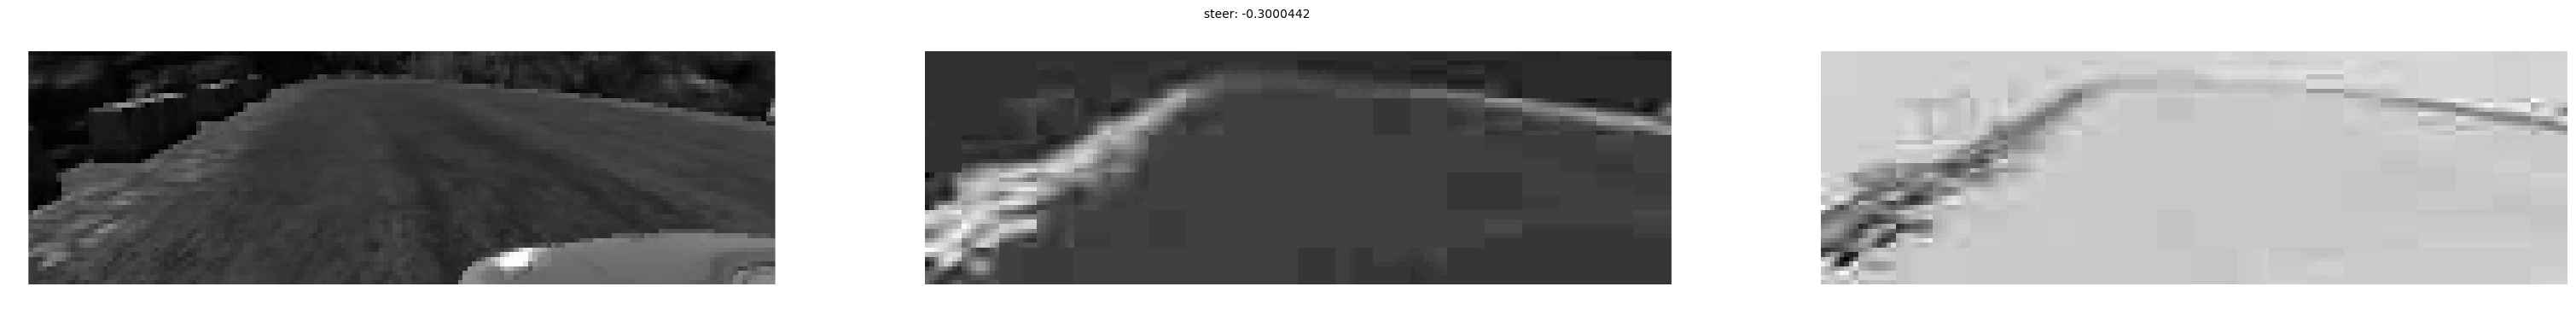

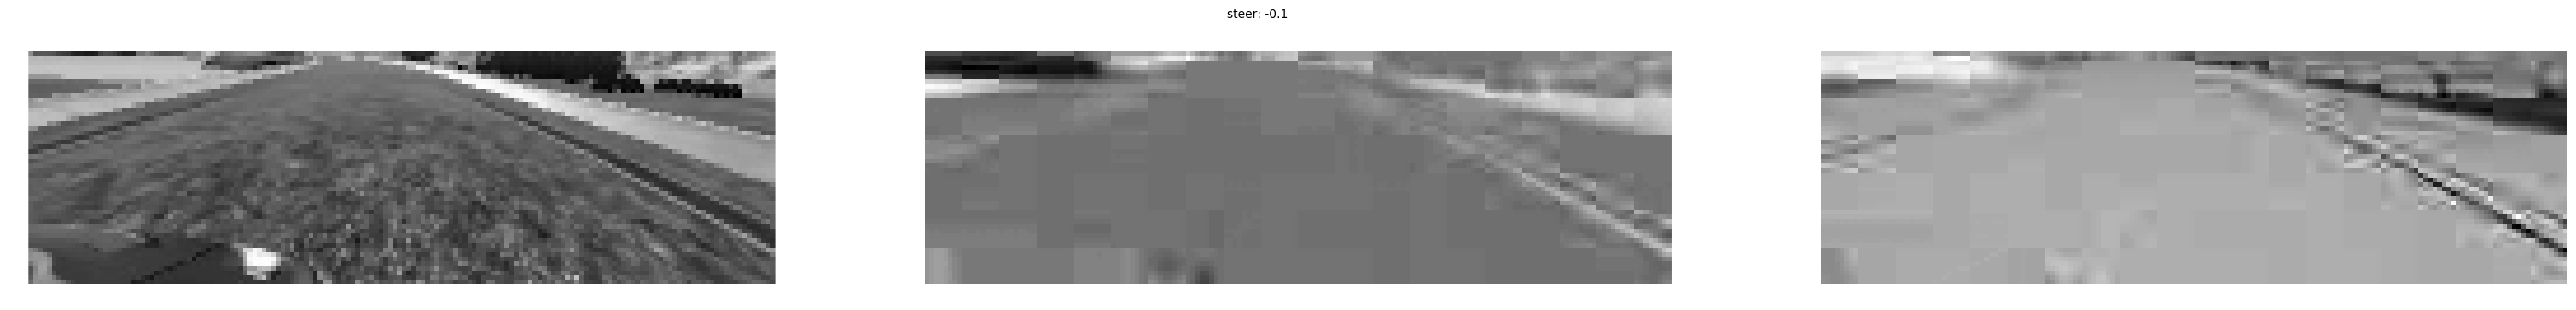

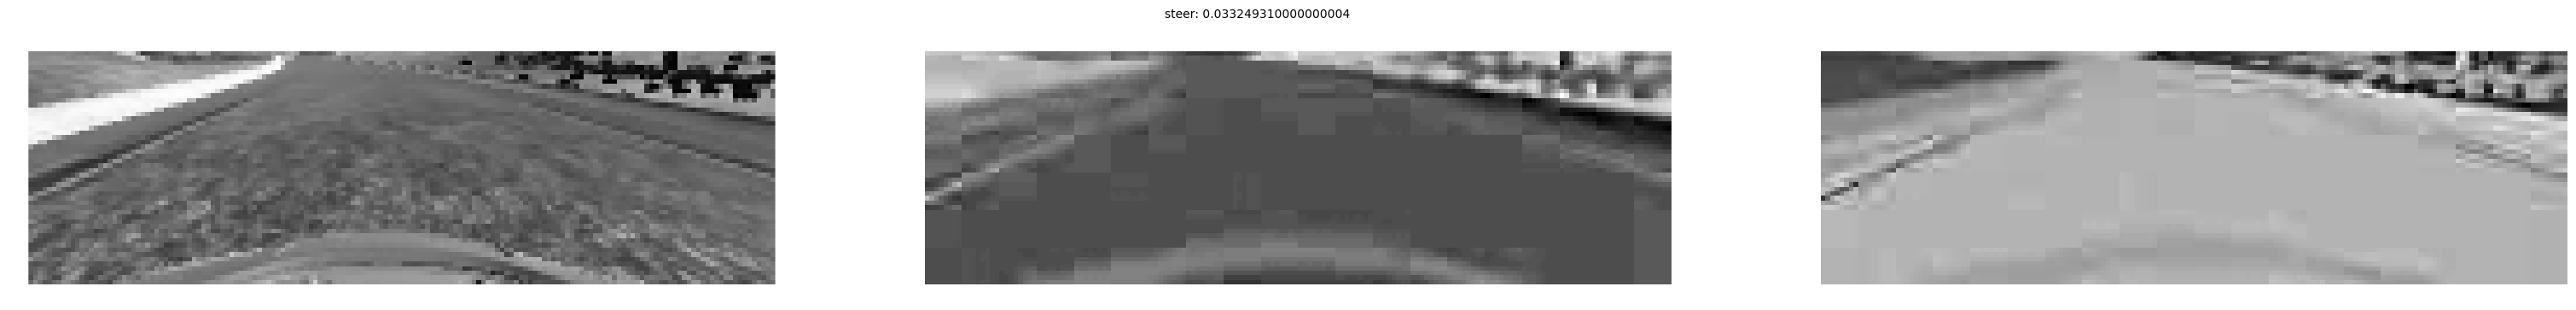

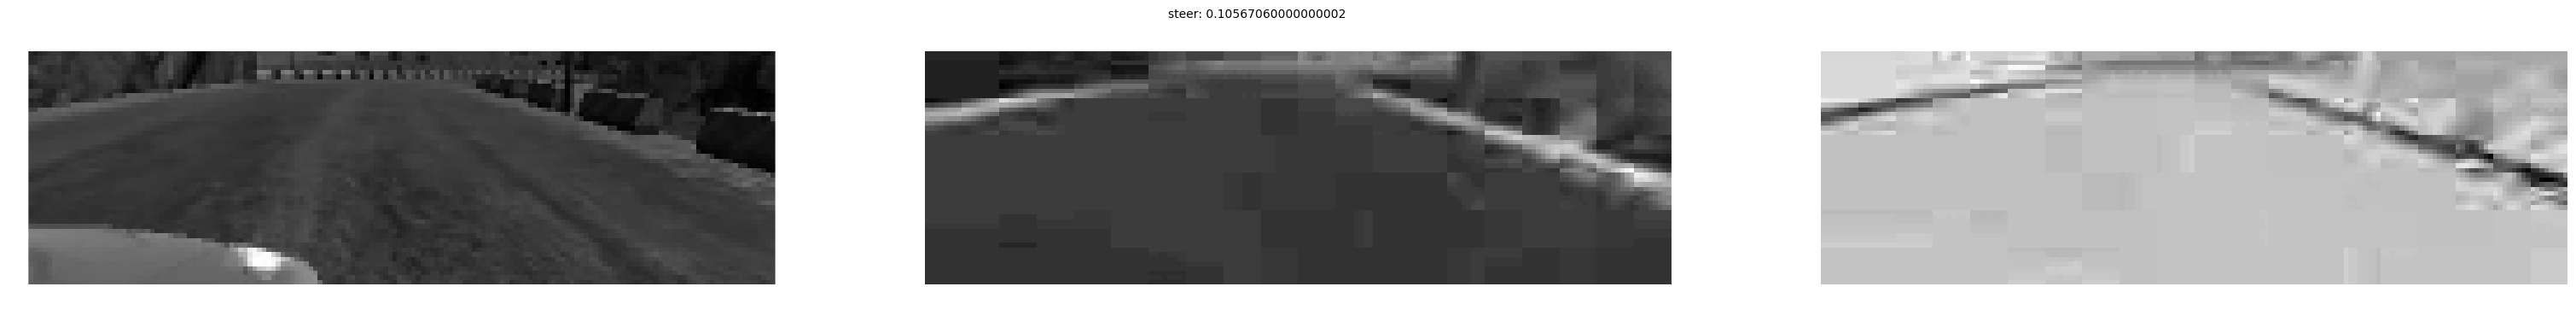

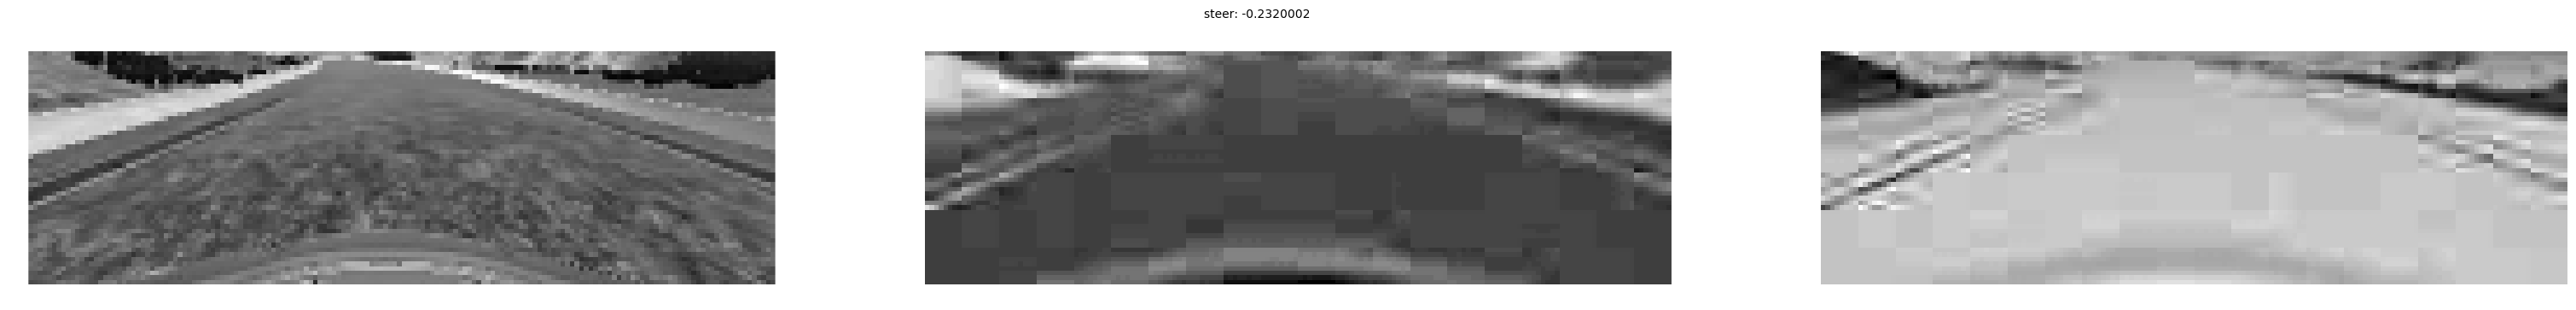

In [22]:
for _ in range(5):
    i = np.random.randint(len(X_val))
    plot_images([X_val[i,:,:,c] for c in range(3)], images_per_line=3, image_size_inches=2, title="steer: {:3}".format(y_train[i]))


In [23]:
from model import model_a

In [25]:
y_train=np.array(y_train)
y_val=np.array(y_val)
#print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)
model = model_a(im_shape)
model.compile(loss='mse', optimizer='adam')

In [32]:
def path_based_generator(X_path, y, batch_size=100):
    while True:
        start = 0
        while start < len(X_path):
            end = min(start + batch_size, len(X_path)+1)
            rv_X = images_for_files(X_path[start:end])
            rv_y = y[start:end].copy()
            yield rv_X,rv_y
            start += batch_size
            

In [27]:
def array_generator(X, y, random_flip = False, batch_size=100):
    #rv_size = (batch_size,X.shape[1], x.shape[2],x.shape[3])
    while True:
        start = 0
        while start < X.shape[0]:
            end = min(start + batch_size, X.shape[0]+1)
            rv_X = X[start:end,:,:,:].copy()
            rv_y= y[start:end].copy()
            for i in range(rv_X.shape[0]):
                if random_flip and coin_flip():
                    rv_X[i,:,:,0] = np.fliplr(rv_X[i,:,:,0])
                    rv_X[i,:,:,1] = np.fliplr(rv_X[i,:,:,1])
                    rv_X[i,:,:,2] = np.fliplr(rv_X[i,:,:,2])
                    rv_y[i] = -rv_y[i]
            yield rv_X,rv_y
            start += batch_size

In [28]:
def coin_flip():
    return np.random.randint(2) == 1

In [30]:
if False: # use array generator with loaded files
    i = 0
    for rv_x,rv_y in array_generator(X_train[5000:5010], y_train[5000:5010], batch_size=2, random_flip=False):
        for j in range(len(rv_x)):
            plt.figure()
            plot_image(rv_x[j,:,:,0],title=rv_y[j])
        i += 1
        if i > 5: 
            break

In [36]:
if use_generator:
    batch_size = 100
    #generator = array_generator(X_train,y_train, batch_size=batch_size, random_flip=False)
    generator = path_based_generator(X_train_path_r,y_train_r, batch_size=batch_size)
    history = model.fit_generator(generator,
    nb_epoch=200,
    samples_per_epoch = len(y_train)//batch_size * batch_size,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint("best_model.h5"), EarlyStopping(patience=5)])

Epoch 1/200
44400/44400 [==============================] - 99s - loss: 0.0246 - val_loss: 0.0175
Epoch 2/200
44402/44400 [==============================] - 100s - loss: 0.0177 - val_loss: 0.0101
Epoch 3/200
44402/44400 [==============================] - 101s - loss: 0.0124 - val_loss: 0.0065
Epoch 4/200
44402/44400 [==============================] - 97s - loss: 0.0093 - val_loss: 0.0060
Epoch 5/200
44402/44400 [==============================] - 96s - loss: 0.0082 - val_loss: 0.0053
Epoch 6/200
44402/44400 [==============================] - 99s - loss: 0.0075 - val_loss: 0.0052
Epoch 7/200
44402/44400 [==============================] - 107s - loss: 0.0071 - val_loss: 0.0050
Epoch 8/200
44402/44400 [==============================] - 114s - loss: 0.0067 - val_loss: 0.0047
Epoch 9/200
44402/44400 [==============================] - 117s - loss: 0.0065 - val_loss: 0.0047
Epoch 10/200
44402/44400 [==============================] - 115s - loss: 0.0064 - val_loss: 0.0045
Epoch 11/200
44402/4440

KeyboardInterrupt: 

In [ ]:
if not use_generator:
    history = model.fit(X_train, y_train,shuffle=True,
        nb_epoch=100, batch_size=100,
        validation_data=(X_val, y_val),
        callbacks=[ModelCheckpoint("best_model.h5"), EarlyStopping(patience=5)])

In [ ]:
y_train_predict=model.predict(X_train)
print(max(y_train), min(y_train), max(y_train_predict), min(y_train_predict))
print(np.mean(y_train),np.mean(y_train_predict))


In [ ]:

plt.figure(figsize=(10,10))
plt.plot(y_train,color='b')
plt.plot(y_train_predict,color='g')

plt.title("Actual(blue) vs. Predicted(green) steering angles - training set")

In [ ]:
y_val_predict = model.predict(X_val)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(y_val, color='b')
plt.plot(y_val_predict, color='g')
plt.title("Actual(blue) vs. Predicted(green) steering angles - validation set")


In [ ]:
plt.figure()
r=[min(y_train),max(y_train)]
plt.plot(r,r,"k--",linewidth=2,alpha=0.5)

#plt.plot([0, 0, 100, 250], 'k-', lw=2)
plt.scatter(y_train, y_train_predict,alpha=0.1)
plt.ylabel("predicted")
plt.xlabel("actual")
plt.title("Prediction correlation on training set")
plt.show()


In [ ]:
plt.scatter(y_val,y_val_predict,alpha=0.1)
r=[min(y_train),max(y_train)]
plt.plot(r,r,"k--",linewidth=2,alpha=0.5)
plt.ylabel("predicted")
plt.xlabel("actual")
plt.title("Prediction correlation on validation set")

In [ ]:
#model.save('model_a_v00304.h5')
def save_model_to_json(model, file_path='model.json'):
    json = model.to_json()
    with open(file_path, 'w') as f:
        f.write(json)
        
def save_weights(model, file_path='model.h5'):
    model.save_weights(file_path)

def save_all():
    save_model_to_json(model)
    save_weights(model)



In [ ]:
save_all()